In [19]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
from torchvision.io import read_image
from torchvision import transforms
from torchvision.transforms import ToTensor
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split


In [20]:
train_annotation_file = 'task2/train_data/annotations.csv'
train_img_labeled_dir = 'images/labeled/'

val_img_dir = 'task2/val_data/'

In [21]:
df = pd.read_csv(train_annotation_file)

In [22]:
df.head()

,renamed_path,label_idx
0,task2/train_data/images/labeled/0.jpeg,0
1,task2/train_data/images/labeled/1.jpeg,0
2,task2/train_data/images/labeled/2.jpeg,0
3,task2/train_data/images/labeled/3.jpeg,0
4,task2/train_data/images/labeled/4.jpeg,0


In [23]:
print("Number of rows in the training dataset: ",df.shape[0])
print("Number of classes: ", df['label_idx'].nunique())
print("Percentage of each class in the training dataset:\n\n",df['label_idx'].value_counts()*100/df.shape[0])

Number of rows in the training dataset:  50000
Number of classes:  100
Percentage of each class in the training dataset:

 label_idx
12    1.984
94    1.836
24    1.778
59    1.768
5     1.720
      ...  
7     0.726
97    0.726
18    0.724
11    0.722
46    0.722
Name: count, Length: 100, dtype: float64


In [24]:
train_data, test_data = train_test_split(df, test_size=0.2, stratify=df['label_idx'], random_state=42)

In [25]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # le decomentam ptr train
    transforms.RandomRotation(degrees=15), # le decomentam ptr train
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),

])

In [26]:
class AAITDataset(Dataset):
    def __init__(self, dataset, img_dir, is_train=True, transform=None, target_transform=None):
        self.is_train = is_train
        if self.is_train:
            self.img_labels = dataset
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        if self.is_train:
            return len(self.img_labels)
        else:
            self.img_files = [f for f in os.listdir(self.img_dir) if os.path.isfile(os.path.join(self.img_dir, f))]
            return len(self.img_files)

    def __getitem__(self, idx):
        if self.is_train:
            img_path = self.img_labels.iloc[idx, 0]
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            #print(image)
            if image.size()[0] == 1:
                image = image.expand(3, -1, -1)
            label = self.img_labels.iloc[idx, 1]
            
            if self.target_transform:
                label = self.target_transform(label)
            return image, label, img_path
        else: 
            img_path = os.path.join(self.img_dir, self.img_files[idx])
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            if image.size(0) == 1:
                image = image.expand(3, -1, -1)
            
            return image, img_path

In [27]:
train_dataset = AAITDataset(train_data, train_img_labeled_dir, is_train=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = AAITDataset(test_data, train_img_labeled_dir, is_train=True, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 3, 64, 64])
Labels batch shape: torch.Size([64])


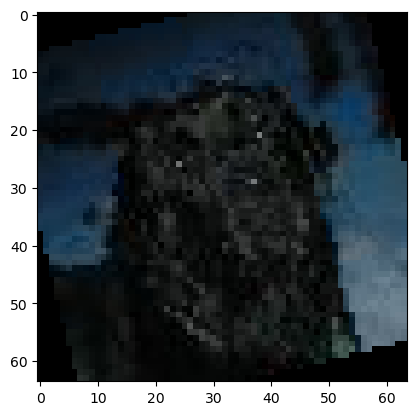

Label: 49


In [28]:
train_features, train_labels, _ = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.permute(1, 2, 0), cmap="gray")
plt.show()
print(f"Label: {label}")

In [29]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    print(mps_device)
else:
    print("MPS not found!")

mps


In [30]:
%%time
from torchvision import models

class CustomModel(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(CustomModel, self).__init__()
    
        self.resnet50 = models.resnet50(weights="IMAGENET1K_V2")

        num_features = self.resnet50.fc.in_features
        self.dropout = nn.Dropout(p=0.1)
        self.resnet50.fc = nn.Sequential(
            nn.Linear(num_features, 1024),
            nn.ReLU(),
            self.dropout,
            nn.Linear(1024, num_classes)
        )
        #self.resnet50.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        # Forward pass through the network
        return self.resnet50(x)


model = CustomModel(num_classes=100, pretrained=True).to(mps_device)

def train_model(model, train_dataloader, criterion, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for images, labels, _ in tqdm(train_dataloader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = total_loss / len(train_dataloader)
        epoch_acc = 100 * correct / total
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels, _ in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, accuracy, precision, recall, f1

criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(teacher_model.parameters(), lr=0.00001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train_model(model, train_dataloader, criterion, optimizer, epochs=20, device=mps_device)
avg_loss, acc, prec, rec, f1 = evaluate_model(model, test_dataloader, criterion, mps_device)
print("Results:")
print("Average loss: ", avg_loss)
print("Accuracy: ", acc*100)
print("Precision: ", prec*100)
print("Recall: ", rec*100)
print("F1 score: ", f1*100)

100%|██████████| 625/625 [02:06<00:00,  4.95it/s]


Epoch 1/20, Loss: 3.8888, Accuracy: 17.04%


100%|██████████| 625/625 [02:07<00:00,  4.90it/s]


Epoch 2/20, Loss: 2.0486, Accuracy: 47.85%


100%|██████████| 625/625 [02:05<00:00,  4.96it/s]


Epoch 3/20, Loss: 1.6356, Accuracy: 54.69%


100%|██████████| 625/625 [02:02<00:00,  5.08it/s]


Epoch 4/20, Loss: 1.4565, Accuracy: 58.31%


100%|██████████| 625/625 [02:03<00:00,  5.05it/s]


Epoch 5/20, Loss: 1.3232, Accuracy: 60.96%


100%|██████████| 625/625 [02:06<00:00,  4.96it/s]


Epoch 6/20, Loss: 1.2260, Accuracy: 62.97%


100%|██████████| 625/625 [02:04<00:00,  5.02it/s]


Epoch 7/20, Loss: 1.1468, Accuracy: 65.01%


100%|██████████| 625/625 [01:59<00:00,  5.24it/s]


Epoch 8/20, Loss: 1.0718, Accuracy: 66.54%


100%|██████████| 625/625 [02:01<00:00,  5.16it/s]


Epoch 9/20, Loss: 0.9962, Accuracy: 68.20%


100%|██████████| 625/625 [02:00<00:00,  5.18it/s]


Epoch 10/20, Loss: 0.9367, Accuracy: 69.69%


100%|██████████| 625/625 [02:00<00:00,  5.19it/s]


Epoch 11/20, Loss: 0.8785, Accuracy: 71.44%


100%|██████████| 625/625 [02:01<00:00,  5.16it/s]


Epoch 12/20, Loss: 0.8249, Accuracy: 72.71%


100%|██████████| 625/625 [01:24<00:00,  7.43it/s]


Epoch 13/20, Loss: 0.7703, Accuracy: 74.56%


100%|██████████| 625/625 [01:11<00:00,  8.70it/s]


Epoch 14/20, Loss: 0.7171, Accuracy: 75.88%


100%|██████████| 625/625 [01:24<00:00,  7.42it/s]


Epoch 15/20, Loss: 0.6651, Accuracy: 77.41%


100%|██████████| 625/625 [01:24<00:00,  7.36it/s]


Epoch 16/20, Loss: 0.6238, Accuracy: 78.81%


100%|██████████| 625/625 [01:23<00:00,  7.48it/s]


Epoch 17/20, Loss: 0.5762, Accuracy: 80.22%


100%|██████████| 625/625 [01:22<00:00,  7.60it/s]


Epoch 18/20, Loss: 0.5339, Accuracy: 81.74%


100%|██████████| 625/625 [01:19<00:00,  7.85it/s]


Epoch 19/20, Loss: 0.5019, Accuracy: 82.69%


100%|██████████| 625/625 [01:36<00:00,  6.45it/s]


Epoch 20/20, Loss: 0.4638, Accuracy: 84.14%
Results:
Average loss:  1.6260583677868934
Accuracy:  57.34
Precision:  57.40780760027311
Recall:  57.34
F1 score:  57.00083351724632
CPU times: user 16min 32s, sys: 2min 35s, total: 19min 8s
Wall time: 35min 59s


In [31]:
def generate_pseudo_labels(model, dataloader):
    model.eval()
    pseudo_label_data = []
    with torch.no_grad():
        for images, img_paths in dataloader:
            images = images.to(mps_device)
            outputs = model(images)
            probs, predicted = torch.max(outputs, 1)
            
            
            for img_path, label in zip(img_paths, predicted):
                pseudo_label_data.append((img_path, label.item()))

    pseudo_labels_df = pd.DataFrame(pseudo_label_data, columns=['sample', 'label'])
    return pseudo_labels_df



In [32]:
val_unlabeled_dataset = AAITDataset(None, val_img_dir, is_train=False, transform=transform)
val_unlabeled_dataloader = DataLoader(val_unlabeled_dataset, batch_size=64, shuffle=False)

val_labels = generate_pseudo_labels(model, val_unlabeled_dataloader)
val_labels['sample'] = val_labels['sample'].apply(lambda x: x.split('/')[-1])


In [33]:
val_labels['sort_key'] = val_labels['sample'].str.extract('(\d+)').astype(int)
val_labels.sort_values(by='sort_key', ascending=True, inplace=True)
val_labels.reset_index(inplace=True)
val_labels.drop(columns=['sort_key','index'], inplace=True)

val_labels.to_csv('task2/baseline.csv', index=False)